In [2]:
import re
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import json
from pylab import *
import pandas as pd
from dogues_functions_2 import clean_article_name, plot_category_trends, fetch_pageview_count, normal_data, extract_clean_text, fetch_and_combine_pageview_data, scrape_wikipedia_sub_subheadings_with_links, fetch_pageview_count_dates, fetch_viewcount_df
from scipy import stats


# Loading the data from milestone 2 

In [52]:
#load data into df
df_fakecovidNews = pd.read_csv('./Data/covid-19_misinformation5.csv')

##  Usefull functions and classes

In [4]:
def getSubLinksFromIntro(website, nombreMax=10):
    link = "https://en.wikipedia.org/wiki/"+website

    #load online the html file 
    r = requests.get(link)
    soup = BeautifulSoup(r.text, 'html.parser')

    intro = soup.find_all('div', attrs={'class':'mw-content-ltr mw-parser-output'})[0].find_all('p')
    #get the all the href
    links = []
    for i in intro:
        #get the link and not the <a> tag
        try:
            currentLink = i.find_all('a', href=True)[0]['href']
            if(currentLink[0] == '#'):
                continue
            links.append(currentLink)
        except:
            pass

        if(len(links) >= nombreMax):
            break
    
    return links

In [5]:

 
def existed(article, dateMin="2020-03-01"):
    #check if the first timestamp is less dateMin 
    if pd.Timestamp(article.iloc[0]['timestamp']) <= pd.Timestamp(dateMin):
        return True
    else:
        return False  


def getSubLinksFromIntroPablo(links):
    views = []
    for link in links:
        result = fetch_pageview_count("en", link)
        if(len(result) != 0):
            views.append(result)

    return views[0]



In [6]:
#make subplot of all the views of dfViewFinal
def plotAllInfos(topic, function):

    fig, axs = plt.subplots(len(topic.dfViewFinal)//3 + 1, 3, figsize=(15, len(topic.dfViewFinal)), sharex=True)
    for i in range(len(topic.dfViewFinal)):
        plt.xticks(rotation=45)
        axs[i//3, i%3].plot(topic.dfViewFinal[i]['timestamp'], function(topic.dfViewFinal[i]['views']))
        axs[i//3, i%3].set_title(topic.dfViewFinal[i]['article'].unique()[0])

        #axs[i].set_title(topic.dfViewFinal[i]['article'])
        #make rotation of x axis
        axs[i//3, i%3].set_ylabel('Views')
        axs[i//3, i%3].set_xlabel('Date')


    #make subplot of all the views of dfViewSubLinksFinal
    fig, axs = plt.subplots(len(topic.dfViewSubLinksFinal)//3+1, 3, figsize=(15, len(topic.dfViewSubLinksFinal)), sharex=True)
    for i in range(len(topic.dfViewSubLinksFinal)):
        plt.xticks(rotation=45)
        axs[i//3, i%3].plot(topic.dfViewSubLinksFinal[i]['timestamp'], function(topic.dfViewSubLinksFinal[i]['views']))
        axs[i//3, i%3].set_title(topic.dfViewSubLinksFinal[i]['article'].unique()[0])
        #axs[i].set_title(topic.dfViewFinal[i]['article'])
        #make rotation of x axis
        axs[i//3, i%3].set_ylabel('Views')
        axs[i//3, i%3].set_xlabel('Date')


def plotMainInfos(topic, function):
    fig, axs = plt.subplots(len(topic.dfViewFinal)//3 + 1, 3, figsize=(15, len(topic.dfViewFinal)), sharex=True)
    for i in range(len(topic.dfViewFinal)):
        plt.xticks(rotation=45)
        axs[i//3, i%3].plot(topic.dfViewFinal[i]['timestamp'], function(topic.dfViewFinal[i]['views']))
        axs[i//3, i%3].set_title(topic.dfViewFinal[i]['article'].unique()[0])

        #axs[i].set_title(topic.dfViewFinal[i]['article'])
        #make rotation of x axis
        axs[i//3, i%3].set_ylabel('Views')
        axs[i//3, i%3].set_xlabel('Date')


def getViewsNormalizedTotal(topic, function):
    dftemp = topic.dfViewFinal.copy()

    columns = ["timestamp", "viewNormalized"]
    newdf = pd.DataFrame(columns=columns)

    for i in range(len(topic.dfViewFinal)):
        dftemp[i]["viewNormalized"] = function(topic.dfViewFinal[i]['views'])
        newdf = pd.concat([newdf, dftemp[i][["timestamp", "viewNormalized"]]], ignore_index=True)

    newdf = newdf.groupby("timestamp").sum()

    return newdf
    



def getInfoByArticles(df):
    columns = ["article", "views"]
    newdf = pd.DataFrame(columns=columns)

    for i in range(len(df)):
        newdf = pd.concat([newdf, df[i][["article", "views"]]], ignore_index=True)

    mean = newdf.groupby("article").mean()
    median = newdf.groupby("article").median()
    std = newdf.groupby("article").std()



    #rename the columns
    mean.columns = ["mean"]
    median.columns = ["median"]
    std.columns = ["std"]
    newdf = pd.concat([mean, median, std], axis=1)


    return newdf


def getSelectedArticlesFromViews(topic):
        
    # Existing features
    articlesName = []
    mean = []
    median = []
    std = []
    maxi = []
    mini = []
    stkew = []
    kurt = []
    mode = []
    range_val = []

    for i in range(len(topic.dfView)):
        views_data = topic.dfView[i]["views"]

        articlesName.append(topic.dfView[i].article.unique()[0])
        
        mean.append(np.mean(views_data))
        median.append(np.median(views_data))
        std.append(np.std(views_data))
        maxi.append(np.max(views_data))
        mini.append(np.min(views_data))
        stkew.append(stats.skew(views_data))
        kurt.append(stats.kurtosis(views_data))
        mode.append(stats.mode(views_data).mode[0])  # Mode
        range_val.append(np.ptp(views_data))  # Range

    labelOfKey = pd.DataFrame()
    labelOfKey["key"] = articlesName

    labelOfKey["mean"] = mean
    labelOfKey["median"] = median
    labelOfKey["std"] = std
    labelOfKey["maxi"] = maxi
    labelOfKey["mini"] = mini
    labelOfKey["skew"] = stkew
    labelOfKey["kurt"] = kurt
    labelOfKey["mode"] = mode
    labelOfKey["range"] = range_val


    return labelOfKey, labelOfKey[(labelOfKey["skew"] < 3) & (labelOfKey["maxi"] < 50000) & (labelOfKey["kurt"] < 15)]
    

 Functions for normalization of the data (ex relative increase ect ect)

In [7]:

def standarization(array):
    return (array - np.mean(array)) / np.std(array)

def minMax(array):
    return (array - np.min(array)) / (np.max(array) - np.min(array))

def nonefunction(array):
    return array

In [8]:
class wikiTopic:
    df = []

    links = []
    dfView = []
    dfViewFinal = []

    dfSubLinks = []
    dfViewSubLinks = []
    dfViewSubLinksFinal = []

    dfLInksPerArticle = []

    dfSeelectArticles = []
    featureInfo = []

    def __init__(self, df, Maintopic):

        self.dfView = []
        self.dfViewFinal = []
        self.dfViewSubLinks = []
        self.dfViewSubLinksFinal = []
        
        indexes = df["Main Heading"]==Maintopic
        self.df = df[indexes]

        self.extractLinksFromDf()
        self.getViews()

        self.getSublinks()
        #self.getViewsSubLinks()

        self.featureInfo, self.selectedArticles = getSelectedArticlesFromViews(self)

    def extractLinksFromDf(self):

        linksFinal = []
        for links in self.df.Links:
            links = links[1:-1]
            links = links.split(',')

            links = [re.sub(r'[\[\]\'\s]', '', link) for link in links]
            links = [re.sub(r'/wiki/', '', link) for link in links]
            
            #concatenate the list
            linksFinal = linksFinal + links
        
        self.links = list(set(linksFinal))

    def getViews(self):
        #fetch view counts
        viewsdf = getSubLinksFromIntroPablo([self.links])
        keys = list(viewsdf.keys())
        #make a list of df 
        for i in range(len(keys)):
            if(existed(viewsdf[keys[i]])):
                self.dfViewFinal.append(viewsdf[keys[i]])
            self.dfView.append(viewsdf[keys[i]])
            
    

    def getSublinks(self):
        for i in range(len(self.links)):
            allSublinks = getSubLinksFromIntro(self.links[i])
            allSublinks = [re.sub(r'/wiki/', '', link) for link in allSublinks]
            #if the sublinks have "#cite_" remove them 
            allSublinks = [link for link in allSublinks if "#cite_" not in link]
            self.dfSubLinks = self.dfSubLinks + allSublinks

        self.dfSubLinks = list(set(self.dfSubLinks))

    def getViewsSubLinks(self):
        #fetch view counts
        viewsdf = getSubLinksFromIntroPablo(self.dfSubLinks)
        keys = list(viewsdf.keys())
        #make a list of df 
        for i in range(len(keys)):
            if(existed(viewsdf[keys[i]])):
                self.dfViewSubLinksFinal.append(viewsdf[keys[i]])
            self.dfViewSubLinks.append(viewsdf[keys[i]])


## Generate the clean columns for the articles

In [56]:
#load data into df
df_fakecovidNews = pd.read_csv('./Data/covid-19_misinformation5.csv')

#drop the columns after the links
df_fakecovidNews.drop(df_fakecovidNews.columns[4:], axis=1, inplace=True)

# add a clomun to df_fakecovidNews named "clean_articles"
df_fakecovidNews["clean_articles"] = 0

In [149]:
df_fakecovidNews["Main Heading"].unique()


array(['Virus origin', 'Incidence and mortality', 'Disease spread',
       'Prevention', 'Treatment'], dtype=object)

In [84]:
#pop all the rows that are in the last column
df_fakecovidNews = df_fakecovidNews[df_fakecovidNews["Main Heading"] != " '/wiki/COVID-19_pandemic_in_Albania'"]
df_fakecovidNews = df_fakecovidNews[df_fakecovidNews["Main Heading"] != 'Efforts to combat misinformation']
df_fakecovidNews = df_fakecovidNews[df_fakecovidNews["Main Heading"] != 'Other']


In [88]:
for k in range(1, len(df_fakecovidNews["Main Heading"].unique())):
    currentHeading = df_fakecovidNews["Main Heading"].unique()[k]
    topic = wikiTopic(df_fakecovidNews, currentHeading)

    allSelectedArticles = list(topic.selectedArticles.key)

    
    processedLinks = []

    for link in df_fakecovidNews[df_fakecovidNews["Main Heading"]==currentHeading]["Links"]:
        link = link[1:-1]
        link = link.split(',')
        link = [re.sub(r'[\[\]\'\s]', '', link) for link in link]
        link = [re.sub(r'/wiki/', '', link) for link in link]
        processedLinks = processedLinks + [link]


    finalSelectedArticles = []
    for i in range(len(processedLinks)):
        selectedRow = []
        for j in range(len(processedLinks[i])):
            if(processedLinks[i][j] in allSelectedArticles):
                selectedRow.append(processedLinks[i][j])
        
        finalSelectedArticles.append(selectedRow)

    finalSelectedArticlesToString = []

    for i in range(len(finalSelectedArticles)):
        finalSelectedArticlesToString.append("', '".join(finalSelectedArticles[i]))
        finalSelectedArticlesToString[i] ="['" + finalSelectedArticlesToString[i] + "']"


    mask = df_fakecovidNews["Main Heading"] == currentHeading
    df_fakecovidNews.loc[mask, "clean_articles"] = finalSelectedArticlesToString
            




Error fetching data for Transmission_of_COVID-19#Asymptomatic_transmission. Status Code: 404
Error fetching data for COVID-19_denial. Status Code: 404


C:\Users\pablo\AppData\Local\Temp\ipykernel_16864\4206312554.py:107: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode.append(stats.mode(views_data).mode[0])  # Mode


Error fetching data for Lidia_Morawska. Status Code: 404
Error fetching data for COVID-19_lockdown_in_India#Janata_Curfew. Status Code: 404


C:\Users\pablo\AppData\Local\Temp\ipykernel_16864\4206312554.py:107: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode.append(stats.mode(views_data).mode[0])  # Mode


Error fetching data for Neck_gaiter#2020. Status Code: 404
Error fetching data for Bootleg_alcohol#Safety. Status Code: 404
Error fetching data for Holy_Synod#The_Greek_Holy_Synod. Status Code: 404
Error fetching data for Misinformation_related_to_vaccination. Status Code: 404
Error fetching data for COVID-19_vaccine_misinformation_and_hesitancy. Status Code: 404
Error fetching data for COVID-19_drug_repurposing_research#Vitamin_D. Status Code: 404
Error fetching data for Vitamin_D#COVID-19. Status Code: 404
Error fetching data for 2020_Tablighi_Jamaat_COVID-19_hotspot_in_Malaysia. Status Code: 404
Error fetching data for Ethanol#Denatured_alcohol. Status Code: 404


C:\Users\pablo\AppData\Local\Temp\ipykernel_16864\4206312554.py:107: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode.append(stats.mode(views_data).mode[0])  # Mode


Error fetching data for Anti-vaccine_activism. Status Code: 404
Error fetching data for Shuanghuanglian. Status Code: 404
Error fetching data for Vitamin_C#COVID-19. Status Code: 404
Error fetching data for Ivermectin_during_the_COVID-19_pandemic. Status Code: 404
Error fetching data for Hydroxychloroquine#COVID-19. Status Code: 404
Error fetching data for COVID-19_drug_repurposing_research#Chloroquine_and_hydroxychloroquine. Status Code: 404
Error fetching data for Chloroquine#COVID-19. Status Code: 404


C:\Users\pablo\AppData\Local\Temp\ipykernel_16864\4206312554.py:107: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode.append(stats.mode(views_data).mode[0])  # Mode


In [143]:
for i in range(len(df_fakecovidNews)):
    df_fakecovidNews["clean_articles"][i] = df_fakecovidNews["clean_articles"][i].replace("'/wiki/'", "'/wiki/")
    df_fakecovidNews["clean_articles"][i] = df_fakecovidNews["clean_articles"][i].replace('"', "")

## Manual search

In [168]:
topic.dfView[0]

,project,article,granularity,timestamp,access,agent,views
0,en.wikipedia,United_States_biological_weapons_program,daily,2020-01-01,all-access,user,84
1,en.wikipedia,United_States_biological_weapons_program,daily,2020-01-02,all-access,user,127
2,en.wikipedia,United_States_biological_weapons_program,daily,2020-01-03,all-access,user,123
3,en.wikipedia,United_States_biological_weapons_program,daily,2020-01-04,all-access,user,129
4,en.wikipedia,United_States_biological_weapons_program,daily,2020-01-05,all-access,user,121
...,...,...,...,...,...,...,...
177,en.wikipedia,United_States_biological_weapons_program,daily,2020-06-26,all-access,user,157
178,en.wikipedia,United_States_biological_weapons_program,daily,2020-06-27,all-access,user,143
179,en.wikipedia,United_States_biological_weapons_program,daily,2020-06-28,all-access,user,169
180,en.wikipedia,United_States_biological_weapons_program,daily,2020-06-29,all-access,user,155


In [63]:
linksToSee =  df_fakecovidNews.iloc[1].Links[1:-1].split(',')

for i in range(len(linksToSee)):
    linksToSee[i] = re.sub(r'[\[\]\'\s]', '', linksToSee[i])
    linksToSee[i] = re.sub(r'/wiki/', '', linksToSee[i])

linksToSee

['Israeli_secret_service',
 'The_Washington_Times',
 'Biosafety_level_4',
 'Wuhan_Institute_of_Virology',
 'Li-Meng_Yan',
 'Preprint',
 'Steve_Bannon',
 'Guo_Wengui',
 'Expatriate',
 'Anti-Chinese_sentiment',
 'Echo_chamber_(media)',
 'Plandemic',
 'The_Epoch_Times',
 'Chinese_Communist_Party',
 'Falun_Gong',
 'Misinformation_related_to_the_COVID-19_pandemic#Misinformation_regarding_virus_origin',
 'Severe_acute_respiratory_syndrome_coronavirus_2',
 'Chinese_Communist_Party',
 'Fort_Detrick',
 'Andrew_Bridgen']

In [67]:
vuews = getSubLinksFromIntroPablo([linksToSee])

Error fetching data for Li-Meng_Yan. Status Code: 404
Error fetching data for Misinformation_related_to_the_COVID-19_pandemic#Misinformation_regarding_virus_origin. Status Code: 404


In [77]:
vuews["Israeli_secret_service"]

,project,article,granularity,timestamp,access,agent,views
0,en.wikipedia,Israeli_secret_service,daily,2020-01-02,all-access,user,0
1,en.wikipedia,Israeli_secret_service,daily,2020-01-08,all-access,user,0
2,en.wikipedia,Israeli_secret_service,daily,2020-01-10,all-access,user,0
3,en.wikipedia,Israeli_secret_service,daily,2020-01-11,all-access,user,1
4,en.wikipedia,Israeli_secret_service,daily,2020-01-12,all-access,user,0
...,...,...,...,...,...,...,...
86,en.wikipedia,Israeli_secret_service,daily,2020-06-25,all-access,user,1
87,en.wikipedia,Israeli_secret_service,daily,2020-06-26,all-access,user,27
88,en.wikipedia,Israeli_secret_service,daily,2020-06-27,all-access,user,0
89,en.wikipedia,Israeli_secret_service,daily,2020-06-29,all-access,user,12


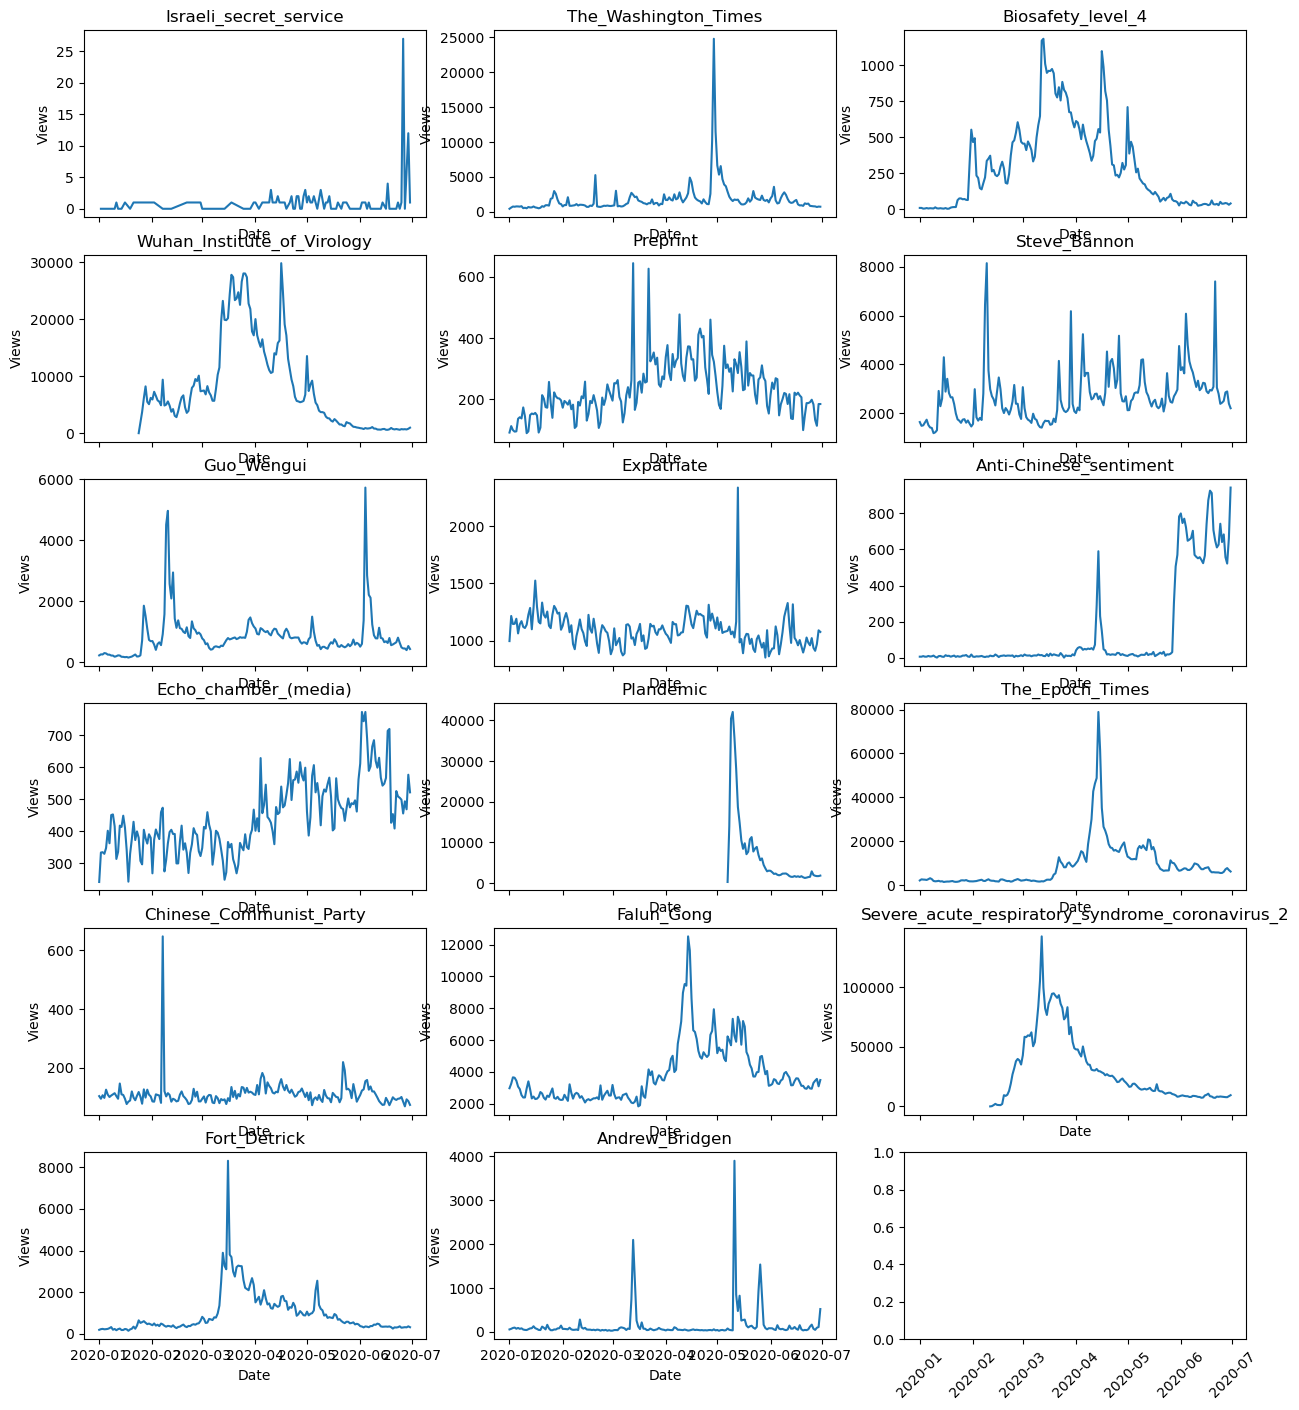

In [114]:
function = nonefunction

Selectedkeys = list(vuews.keys())

fig, axs = plt.subplots(len(keys)//3 + 1, 3, figsize=(15, len(keys)), sharex=True)
for i in range(len(keys)):
    plt.xticks(rotation=45)
    axs[i//3, i%3].plot(vuews[keys[i]]['timestamp'], function(vuews[keys[i]]['views']))
    axs[i//3, i%3].set_title(vuews[keys[i]]['article'].unique()[0])

    #axs[i].set_title(topic.dfViewFinal[i]['article'])
    #make rotation of x axis
    axs[i//3, i%3].set_ylabel('Views')
    axs[i//3, i%3].set_xlabel('Date')



In [142]:
Selectedkeys

['Israeli_secret_service',
 'The_Washington_Times',
 'Biosafety_level_4',
 'Wuhan_Institute_of_Virology',
 'Preprint',
 'Steve_Bannon',
 'Guo_Wengui',
 'Expatriate',
 'Anti-Chinese_sentiment',
 'Echo_chamber_(media)',
 'Plandemic',
 'The_Epoch_Times',
 'Chinese_Communist_Party',
 'Falun_Gong',
 'Severe_acute_respiratory_syndrome_coronavirus_2',
 'Fort_Detrick',
 'Andrew_Bridgen']

let's put some labels to check the similarity

In [165]:
MMethod = {
    'Israeli_secret_service': 1,
    'The_Washington_Times': 0,
    'Biosafety_level_4': 1,
    'Wuhan_Institute_of_Virology': 1,
    'Preprint': 1,
    'Steve_Bannon': 0,
    'Guo_Wengui': 0,
    'Expatriate': 0,
    'Anti-Chinese_sentiment': 1,
    'Echo_chamber_(media)': 1,
    'Plandemic': 1,
    'The_Epoch_Times': 0,
    'Chinese_Communist_Party': 0,
    'Falun_Gong': 1,
    'Severe_acute_respiratory_syndrome_coronavirus_2': 0,
    'Fort_Detrick': 0,
    'Andrew_Bridgen': 0
}

#select the keys that are in the Selectedkeys and in the MMethod
SelectedkeysFinal = [key for key in Selectedkeys if key in MMethod.keys()]

#make a df with the key and the label
labelOfKey = pd.DataFrame()
labelOfKey["key"] = MMethod.keys()
labelOfKey["label"] = MMethod.values()



# Existing features
mean = []
median = []
std = []
maxi = []
mini = []
stkew = []
kurt = []
mode = []
range_val = []

for i in range(len(SelectedkeysFinal)):
    views_data = vuews[Selectedkeys[i]]["views"]
    
    mean.append(np.mean(views_data))
    median.append(np.median(views_data))
    std.append(np.std(views_data))
    maxi.append(np.max(views_data))
    mini.append(np.min(views_data))
    stkew.append(stats.skew(views_data))
    kurt.append(stats.kurtosis(views_data))
    mode.append(stats.mode(views_data).mode[0])  # Mode
    range_val.append(np.ptp(views_data))  # Range

labelOfKey["mean"] = mean
labelOfKey["median"] = median
labelOfKey["std"] = std
labelOfKey["max"] = maxi
labelOfKey["min"] = mini
labelOfKey["skew"] = stkew
labelOfKey["kurt"] = kurt
labelOfKey["mode"] = mode
labelOfKey["range"] = range_val


C:\Users\pablo\AppData\Local\Temp\ipykernel_13084\499209940.py:52: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode.append(stats.mode(views_data).mode[0])  # Mode


c:\Users\pablo\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\pablo\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\pablo\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\pablo\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

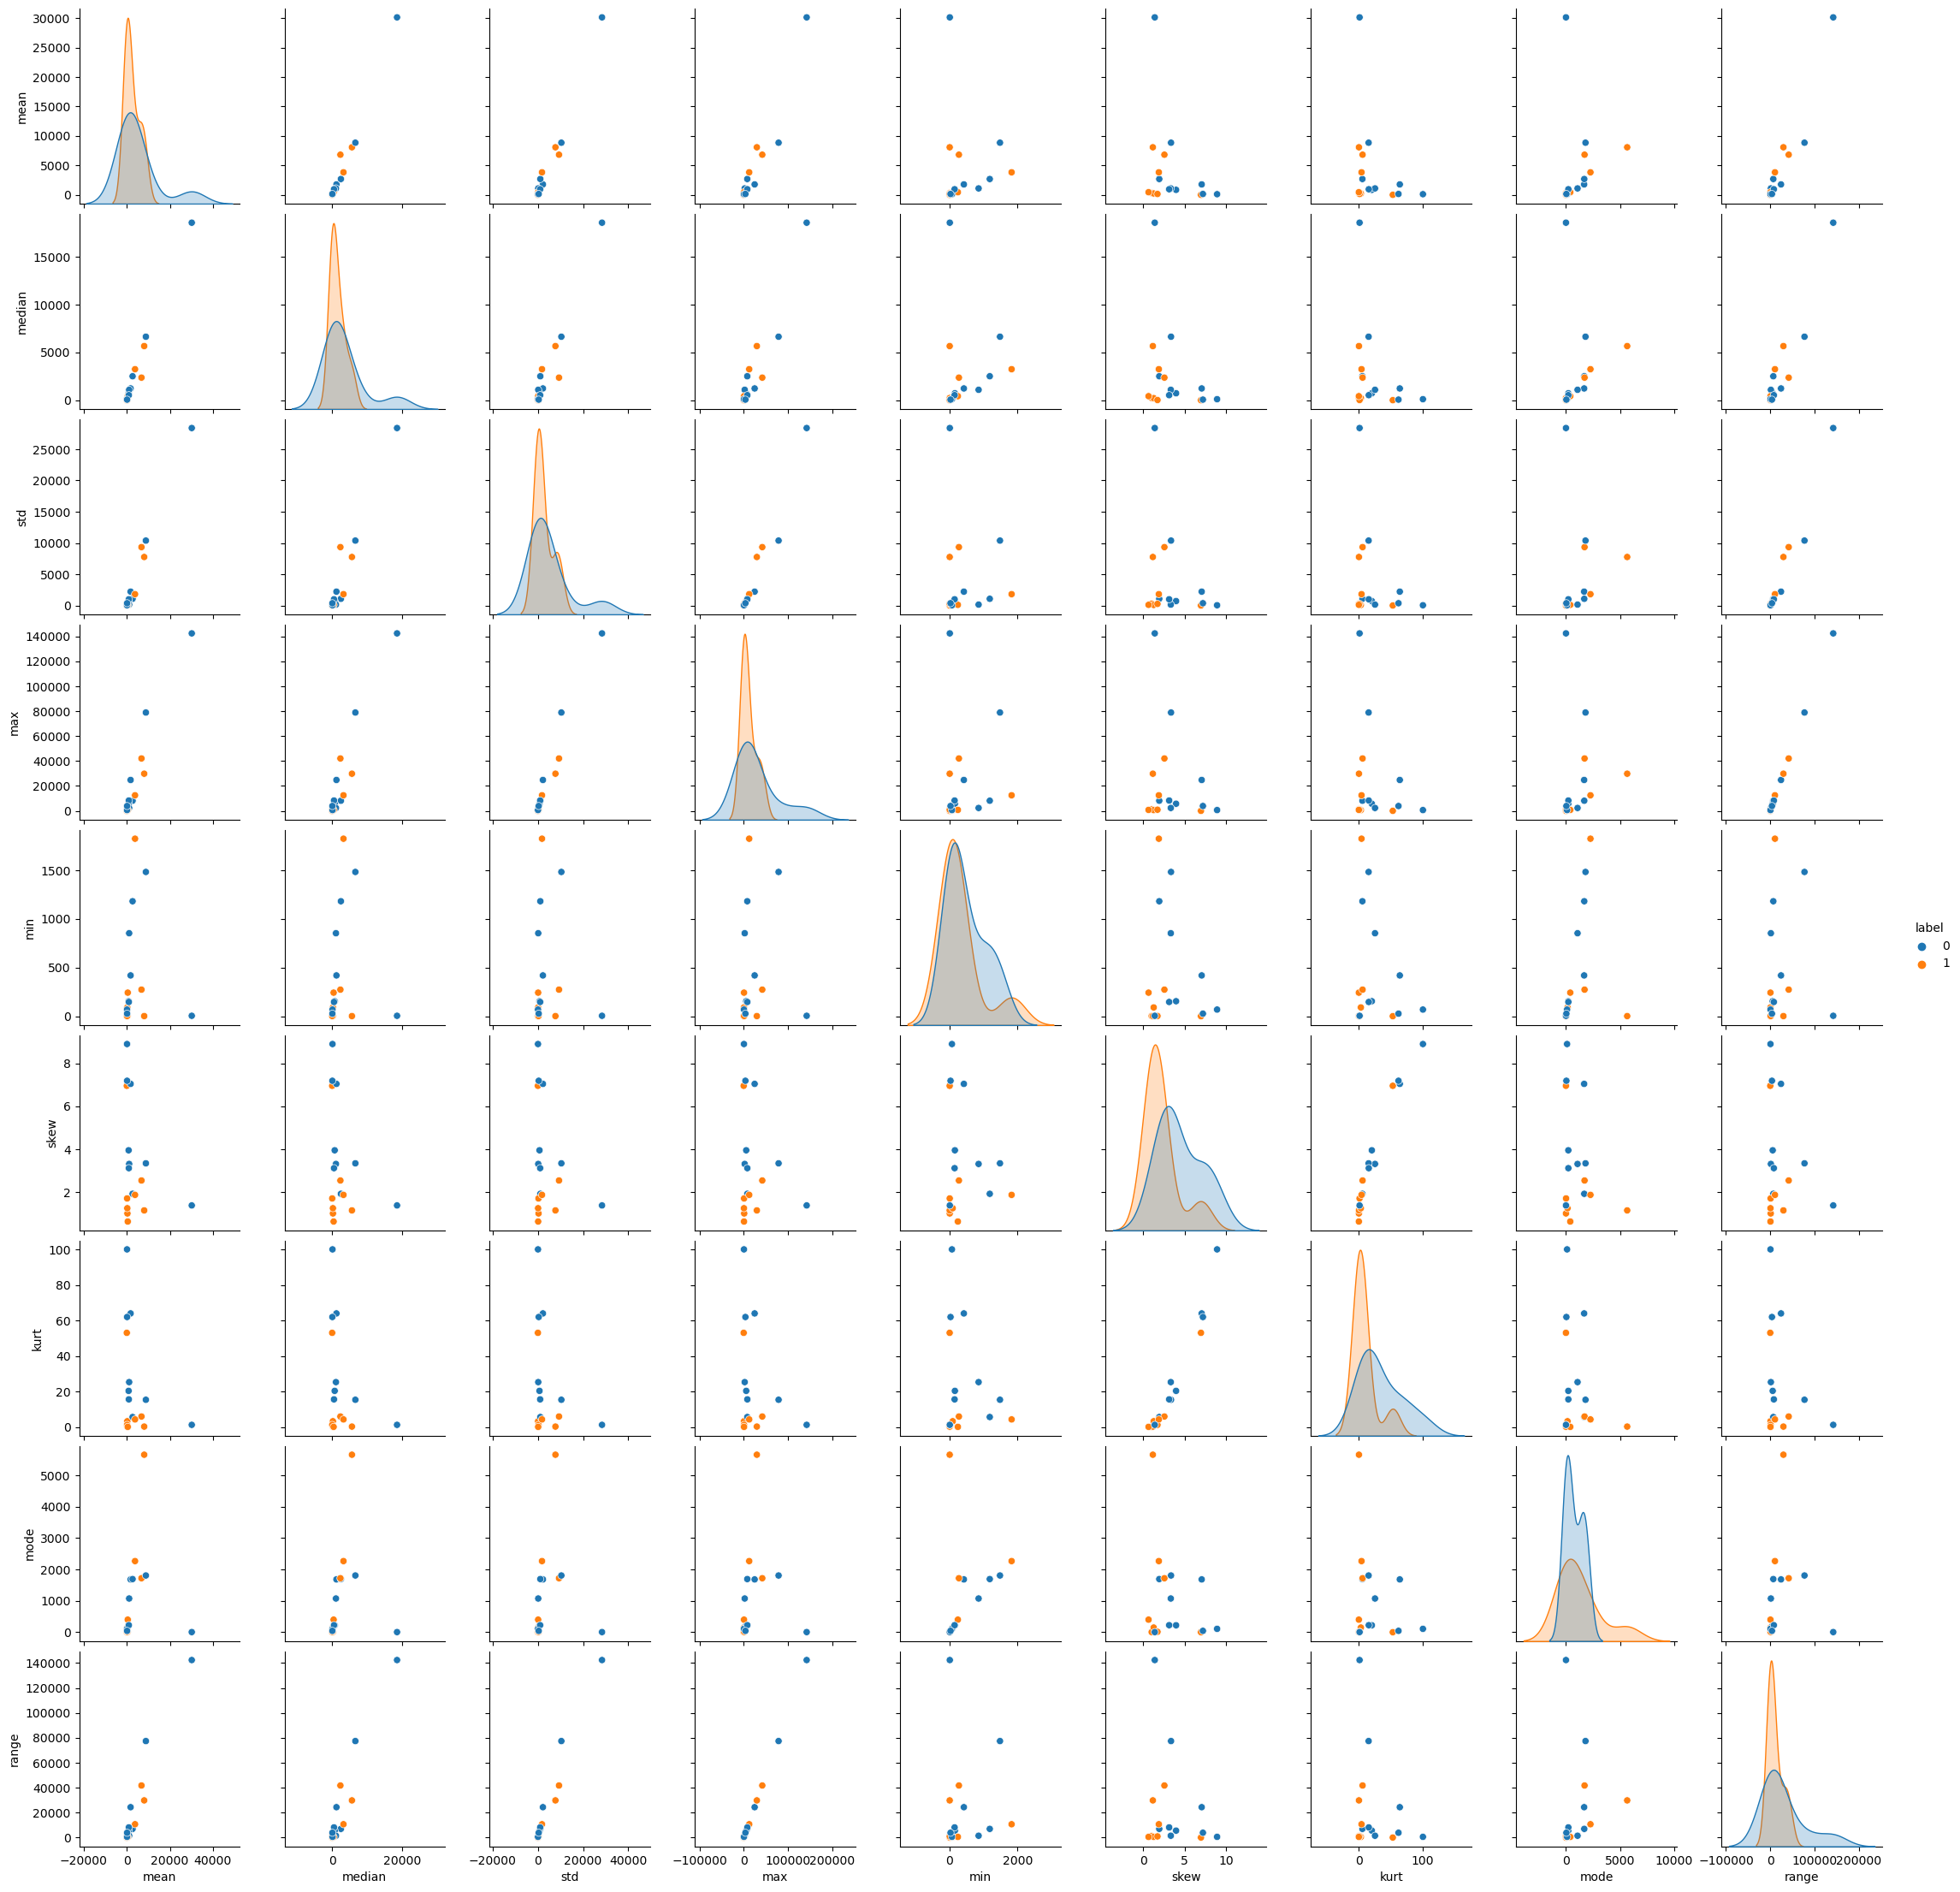

In [166]:
#sns plot with red and green labels all the columns
import seaborn as sns

sns.pairplot(labelOfKey, hue="label")

In [164]:
#select the one with highest mean
labelOfKey[labelOfKey["label"]==1]

,key,label,mean,median,std,max,min,skew,kurt,mode,range
0,Israeli_secret_service,1,1.142857,1.0,3.083353,27,0,6.955455,53.059393,0,27
2,Biosafety_level_4,1,297.027473,224.5,292.629129,1184,2,1.007787,0.214445,4,1182
3,Wuhan_Institute_of_Virology,1,8078.367089,5658.0,7760.824176,29820,1,1.150313,0.307369,5658,29819
4,Preprint,1,233.868132,216.5,89.193543,644,90,1.251485,3.310283,148,554
8,Anti-Chinese_sentiment,1,144.587912,16.0,260.046721,942,2,1.708071,1.274869,13,940
9,Echo_chamber_(media),1,444.945055,420.0,109.245199,773,242,0.631530,0.149920,400,531
10,Plandemic,1,6814.981818,2359.0,9343.099977,42048,273,2.543808,5.979607,1721,41775
13,Falun_Gong,1,3825.785714,3240.5,1817.307876,12513,1825,1.873173,4.338760,2267,10688
14,Fort_Detrick,1,30137.992908,18563.0,28389.111956,142395,4,1.381869,1.286185,4,142391


In [163]:
labelOfKey[labelOfKey["label"]==0].describe()

,label,mean,median,std,max,min,skew,kurt,mode,range
count,7.0,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
mean,0.0,2329.979592,1829.142857,2227.004033,18409.285714,615.000000,4.514041,35.205277,973.000000,17794.285714
std,0.0,2986.663067,2250.906294,3668.941408,27811.594247,562.977797,2.498329,34.138592,775.438371,27443.886956
min,0.0,109.846154,103.500000,46.029475,648.000000,68.000000,1.922953,5.684373,107.000000,580.000000
25%,0.0,897.967033,624.250000,430.617901,4034.500000,150.000000,3.216438,15.509477,222.500000,3531.000000
50%,0.0,1094.642857,1085.000000,999.282872,8151.000000,419.000000,3.343514,20.404725,1074.000000,6969.000000
75%,0.0,2229.357143,1864.500000,1648.381756,16551.500000,1017.500000,5.498406,44.653794,1688.500000,16269.000000
max,0.0,8850.719780,6638.000000,10385.716572,78894.000000,1483.000000,8.902129,100.021296,1808.000000,77411.000000


## global trending

In [194]:
 
# Existing features
articlesName = []
mean = []
median = []
std = []
maxi = []
mini = []
stkew = []
kurt = []
mode = []
range_val = []

for i in range(len(topic.dfView)):
    views_data = topic.dfView[i]["views"]

    articlesName.append(topic.dfView[i].article.unique()[0])
    
    mean.append(np.mean(views_data))
    median.append(np.median(views_data))
    std.append(np.std(views_data))
    maxi.append(np.max(views_data))
    mini.append(np.min(views_data))
    stkew.append(stats.skew(views_data))
    kurt.append(stats.kurtosis(views_data))
    mode.append(stats.mode(views_data).mode[0])  # Mode
    range_val.append(np.ptp(views_data))  # Range

labelOfKey = pd.DataFrame()
labelOfKey["key"] = articlesName

labelOfKey["mean"] = mean
labelOfKey["median"] = median
labelOfKey["std"] = std
labelOfKey["maxi"] = maxi
labelOfKey["mini"] = mini
labelOfKey["skew"] = stkew
labelOfKey["kurt"] = kurt
labelOfKey["mode"] = mode
labelOfKey["range"] = range_val

C:\Users\pablo\AppData\Local\Temp\ipykernel_13084\1044557075.py:25: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode.append(stats.mode(views_data).mode[0])  # Mode


In [181]:
labelOfKey

,key,mean,median,std,max,min,skew,kurt,mode,range
0,United_States_biological_weapons_program,442.021978,385.5,309.194131,1274,84,1.061313,0.359631,155,1190
1,Wuhan_Institute_of_Virology,8078.367089,5658.0,7760.824176,29820,1,1.150313,0.307369,5658,29819
2,Donald_Trump,64141.879121,57090.5,34877.238453,382602,36184,5.633690,42.393816,36184,346418
3,SARS,1604.829670,829.0,1700.768165,8104,126,1.532325,1.740078,234,7978
4,Fatih_Erbakan,16.604396,14.0,15.143910,164,4,6.365056,52.229544,10,160
...,...,...,...,...,...,...,...,...,...,...
311,Canadian_Broadcasting_Corporation,9106.813187,8483.0,3880.590987,22704,4415,1.174531,1.167410,4614,18289
312,5G,14651.357143,9138.5,14800.614707,91944,4913,3.397334,12.319581,6853,87031
313,British_Telecom,50.620879,48.0,17.483562,115,18,0.744309,0.549450,55,97
314,Reuters,2319.340659,2191.0,653.037648,5046,1271,0.854266,0.889182,1498,3775


c:\Users\pablo\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\pablo\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\pablo\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\pablo\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_cat

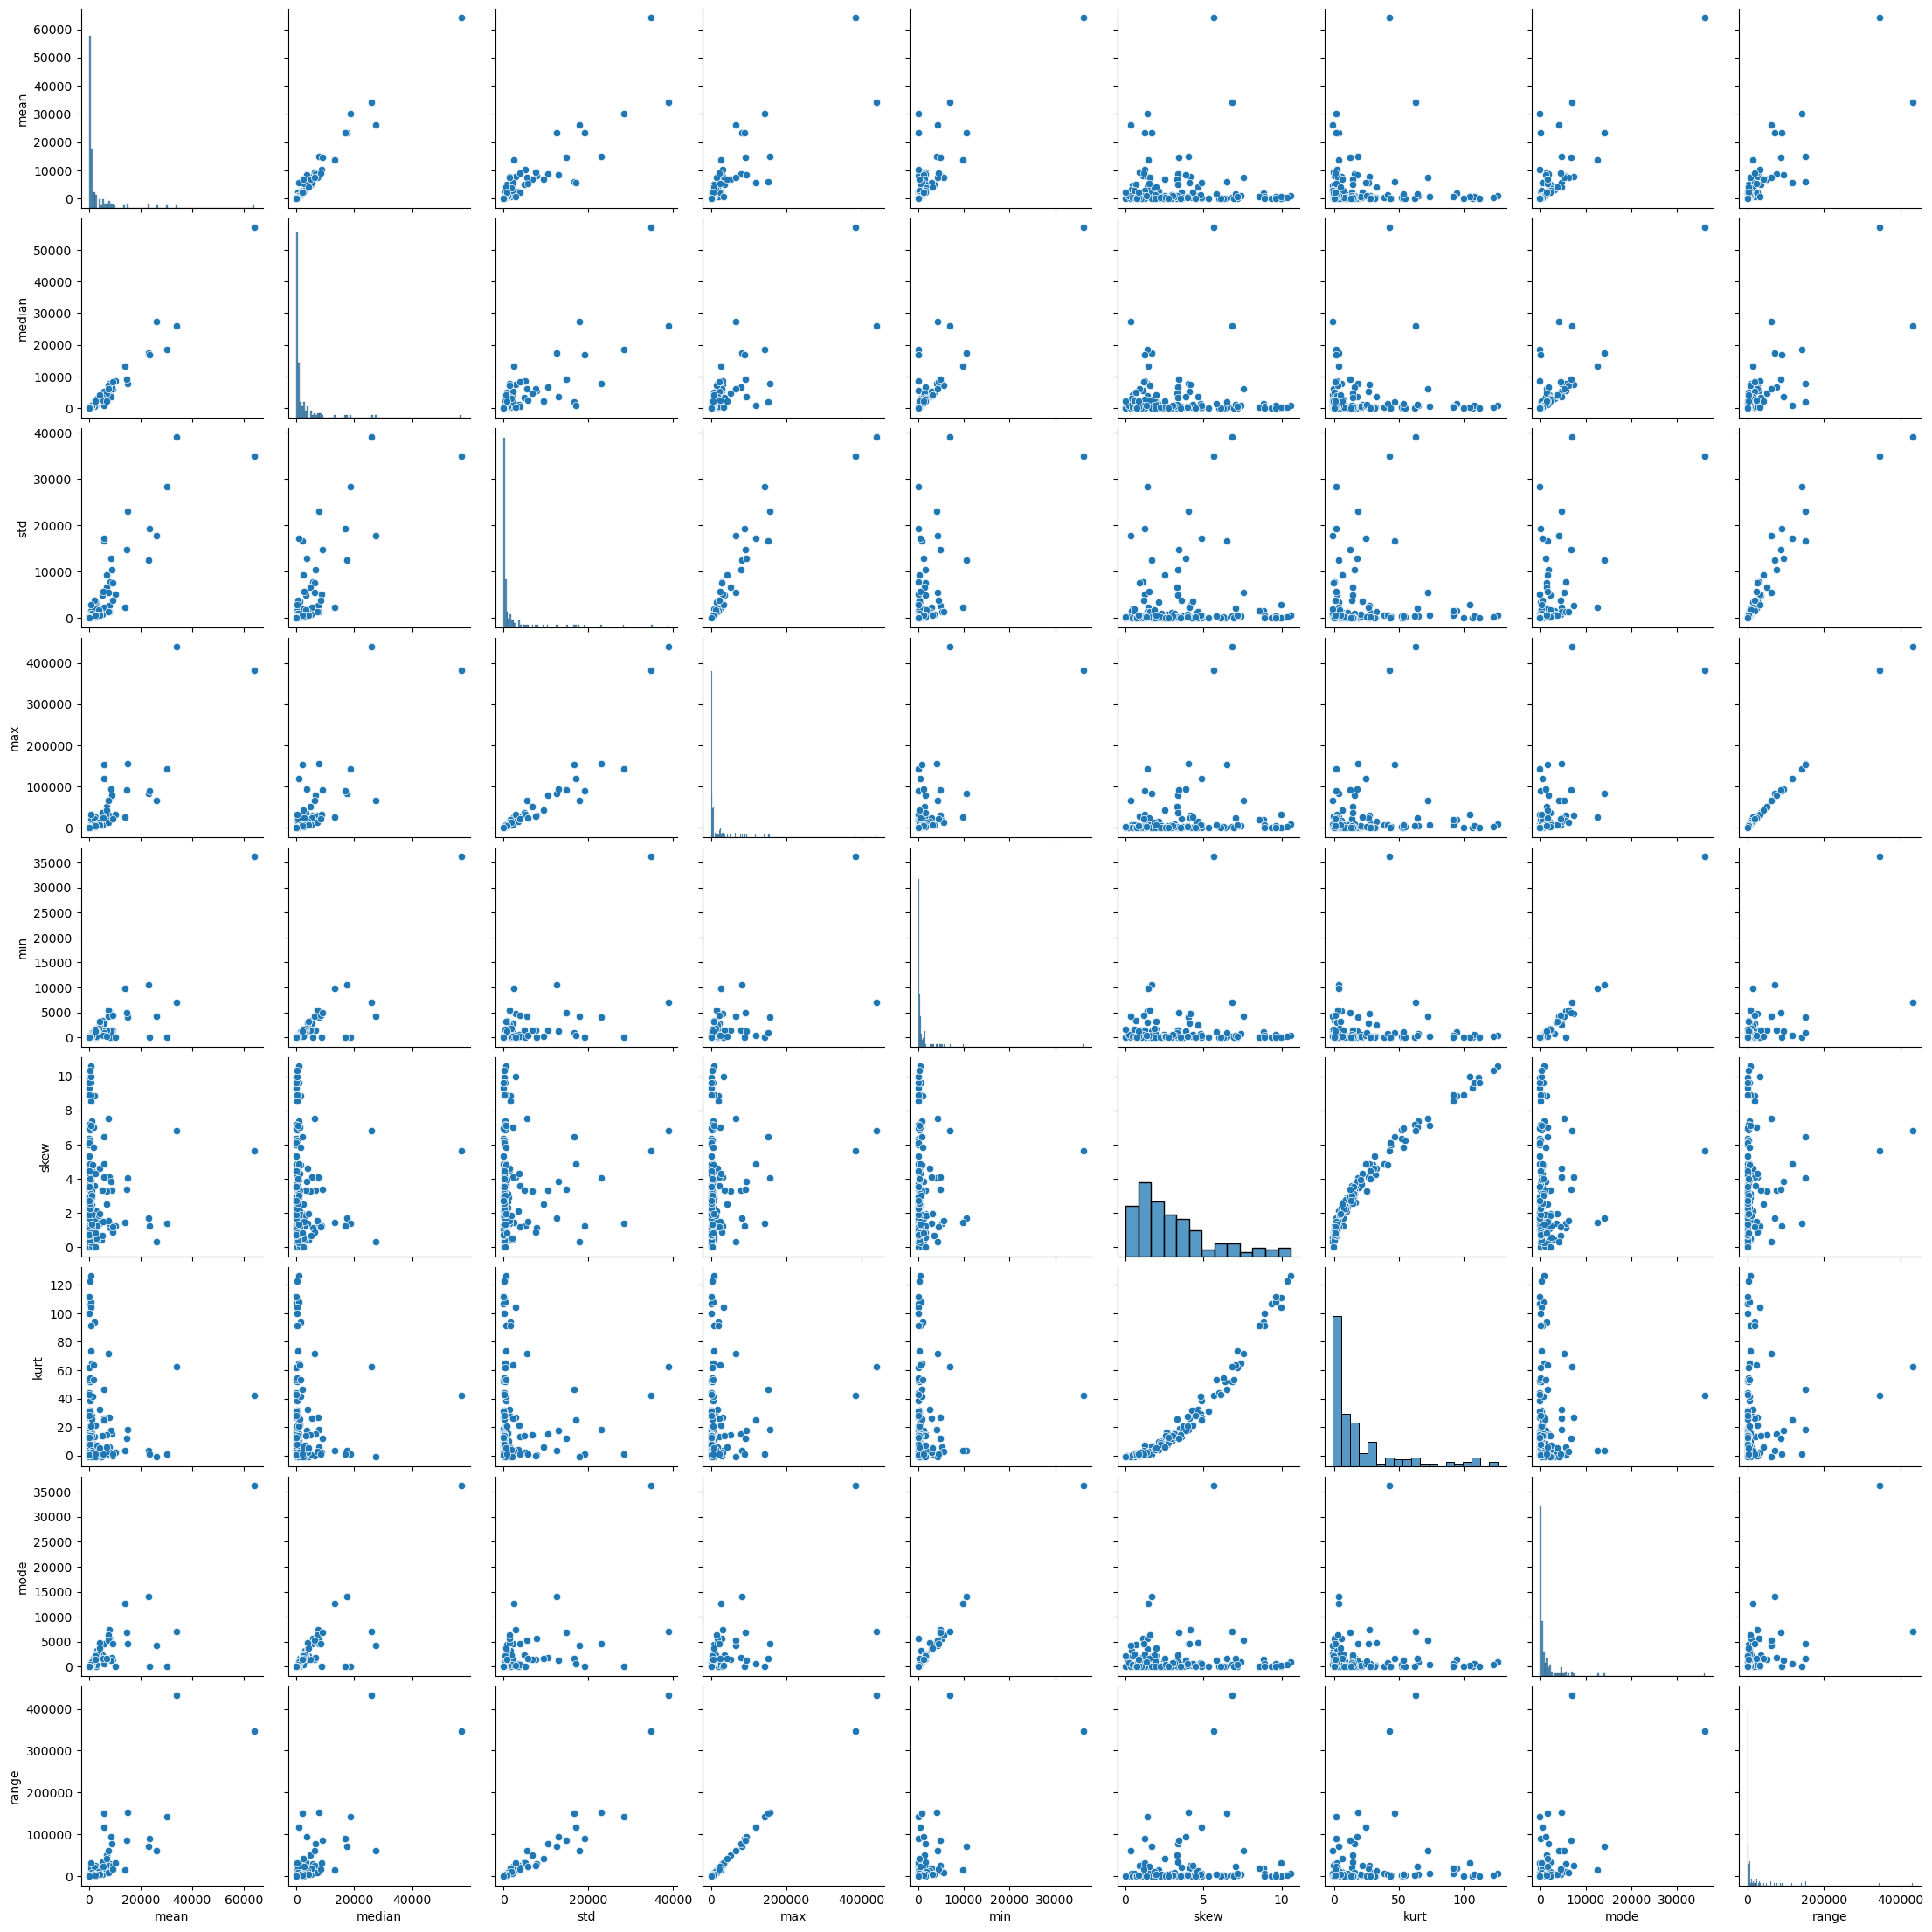

In [183]:
#sns plot with red and green labels all the columns
import seaborn as sns

sns.pairplot(labelOfKey)

In [200]:
selectedArticles = labelOfKey[(labelOfKey["skew"] < 3) & (labelOfKey["maxi"] < 50000) & (labelOfKey["kurt"] < 15)]

set(list(selectedArticles["key"]))


{'2019_Military_World_Games',
 'ABC_News',
 'Agence_France-Presse',
 'Alternative_medicine',
 'American_Public_Health_Association',
 'Anti-Chinese_sentiment',
 'Antisemitic_canard',
 'Astronomy.com',
 'Avian_flu',
 'Bank_of_England',
 'Bank_of_England_£20_note',
 'Biosafety_level_4',
 'British_Telecom',
 'CIA',
 'COVID-19',
 'COVID-19_pandemic_in_Africa',
 'COVID-19_vaccine',
 'Canadian_Broadcasting_Corporation',
 'Cell_(biology)',
 'Chandra_Wickramasinghe',
 'China_News_Service',
 'Chinese_information_operations_and_information_warfare',
 'Compulsory_sterilization',
 'County_Donegal',
 'Crimean–Congo_hemorrhagic_fever',
 'Cyberwarfare_by_Russia',
 'Daily_Mail',
 'Eamonn_Holmes',
 'Eastern_Europe',
 'Echo_chamber_(media)',
 'Falun_Gong',
 'Federal_Office_of_Public_Health',
 'Full_Fact',
 'General_Medical_Council',
 'Good_Morning_Britain_(2014_TV_programme)',
 'Halal',
 'Harvard_University',
 'Health_Canada',
 'Hua_Chunying',
 'Huddersfield',
 'ITV_(TV_channel)',
 'Influenza-like_illnes

In [201]:
len(set(list(selectedArticles["key"])))

92